# Homework 5 - The eternal significance of publications and citations!


In [25]:
#importing necessary libraries
import csv
import numpy as np 
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import ijson
from tqdm import tqdm
import collections
import random

### 1. Data

In [2]:
def extract_paper_info(paper):
    try:
        # extract information
        paper_id = paper.get('id', '')
        title = paper.get('title', '')
        year = paper.get('year', '')

        authors = paper.get('authors', [])
        author_names = ';'.join([author.get('name', '') for author in authors])

        n_citation = paper.get('n_citation', 0)

        doc_type = paper.get('doc_type', np.nan)

        references = paper.get('references', [])
        reference_count = len(references)
        formatted_references = ';'.join([str(ref) for ref in references])

        venue = paper.get('venue', {})
        venue_name = venue.get('raw', '')

        doi = paper.get('doi', '')

        publisher= paper.get('publisher', [])
        
        if doi:
            doi = f"https://doi.org/{doi}"

        return [paper_id, title, year, author_names, n_citation, doc_type, reference_count, formatted_references, venue_name, doi, publisher]
    
    except KeyError as e:
        # handle missing keys or incorrect structure
        print(f"error in extracting paper info: missing key {e}")
        return []
    
def process_batch(batch, csv_writer):
    for paper in batch:
        paper_info = extract_paper_info(paper)
        if paper_info:
            csv_writer.writerow(paper_info)

In [6]:
try:
    with open('dblp.v12.json', 'r') as json_file, open('result.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['id', 'title', 'year', 'authors', 'citations', 'doc_type', 'reference count', 'references', 'venue', 'doi', 'publishers'])

        batch = []
        batch_size = 1000

        for paper in tqdm(ijson.items(json_file, 'item'), desc="processing papers"):
            batch.append(paper)
            if len(batch) >= batch_size:
                process_batch(batch, writer)
                batch = []
        if batch:
            process_batch(batch, writer)

    print("data processing complete.")

except FileNotFoundError:
    print("the file was not found.")
except IOError:
    print("io error occurred.")
except Exception as e:
    print(f"an unexpected error occurred: {e}")

In [4]:
df = pd.read_csv('result.csv')

df.head()

,id,title,year,authors,citations,doc_type,reference count,references,venue,doi,publishers
0,1091,Preliminary Design of a Network Protocol Learn...,2013,Makoto Satoh;Ryo Muramatsu;Mizue Kayama;Kazuno...,1,Conference,2,2005687710;2018037215,International Conference on Human-Computer Int...,https://doi.org/10.1007/978-3-642-39476-8_19,"Springer, Berlin, Heidelberg"
1,1388,Further Results on Independence in Direct-Prod...,2000,Pranava K. Jha,1,Journal,0,NaN,Ars Combinatoria,NaN,NaN
2,1674,A methodology for the physically accurate visu...,2011,G. Beale;G. Earl,1,Conference,15,1535888970;1992876689;1993710814;2035653341;20...,International Conference on Virtual Reality,https://doi.org/10.2312/VAST/VAST11/137-144,Eurographics Association
3,1688,"Comparison of GARCH, Neural Network and Suppor...",2009,Altaf Hossain;Faisal Zaman;M. Nasser;M. Mufakh...,6,Conference,3,1560724230;1986968751;2156909104,Pattern Recognition and Machine Intelligence,https://doi.org/10.1007/978-3-642-11164-8_97,"Springer, Berlin, Heidelberg"
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,Rafael Álvarez;Leandro Tortosa;José-Francisco ...,0,Conference,0,NaN,International Conference on Computer Graphics ...,NaN,NaN


#### Data pre-processing

In [7]:
top_10k_df = df.sort_values(by='citations', ascending=False).head(10000)

# making references list and int
def preprocess_ref(row):
    if isinstance(row, str):
        return [int(ref) for ref in row.split(';') if ref.isdigit()]
    else:
        return []
    
# making authors list
def preprocess_authors(row):
    if isinstance(row, str):
        return row.split(';')
    elif row is None or pd.isna(row):
        return []
    else:
        return row

top_10k_df['references'] = top_10k_df['references'].apply(preprocess_ref)
top_10k_df['authors'] = top_10k_df['authors'].apply(preprocess_authors)

top_10k_df.head()

,id,title,year,authors,citations,doc_type,reference count,references,venue,doi,publishers
4696136,2041404167,The Mathematical Theory of Communication,1949,[C. E. Shannon],48327,Book,0,[],NaN,NaN,NaN
4630907,1639032689,"Genetic algorithms in search, optimization, an...",1989,[David E. Goldberg],44175,Book,0,[],NaN,NaN,NaN
4092588,2912565176,Fuzzy sets,1996,[Lotfi A. Zadeh],42437,NaN,0,[],"Fuzzy sets, fuzzy logic, and fuzzy systems",NaN,NaN
2937610,2151103935,Distinctive Image Features from Scale-Invarian...,2004,[David G. Lowe],35541,Journal,33,"[19720318, 1541642243, 1560959218, 1676552347,...",International Journal of Computer Vision,https://doi.org/10.1023/B:VISI.0000029664.9961...,Kluwer Academic Publishers
4088311,2911964244,Random Forests,2001,[Leo Breiman],34741,NaN,11,"[1507255258, 1580948147, 1605688901, 197584664...",Machine Learning archive,https://doi.org/10.1023/A:1010933404324,NaN


#### Graphs setup

In [8]:
# citation graph initialization 
citation_graph = nx.DiGraph()

paper_ids = set(top_10k_df['id'])

for index, row in top_10k_df.iterrows():
    paper_id = row['id']
    citation_graph.add_node(paper_id)

    references = row['references']
    if references:
        links = [(paper_id, ref) for ref in references if ref in paper_ids]
        citation_graph.add_edges_from(links)

print(f"citation graph has {citation_graph.number_of_nodes()} nodes, and {citation_graph.number_of_edges()} edges.")

citation graph has 10000 nodes, and 52252 edges.


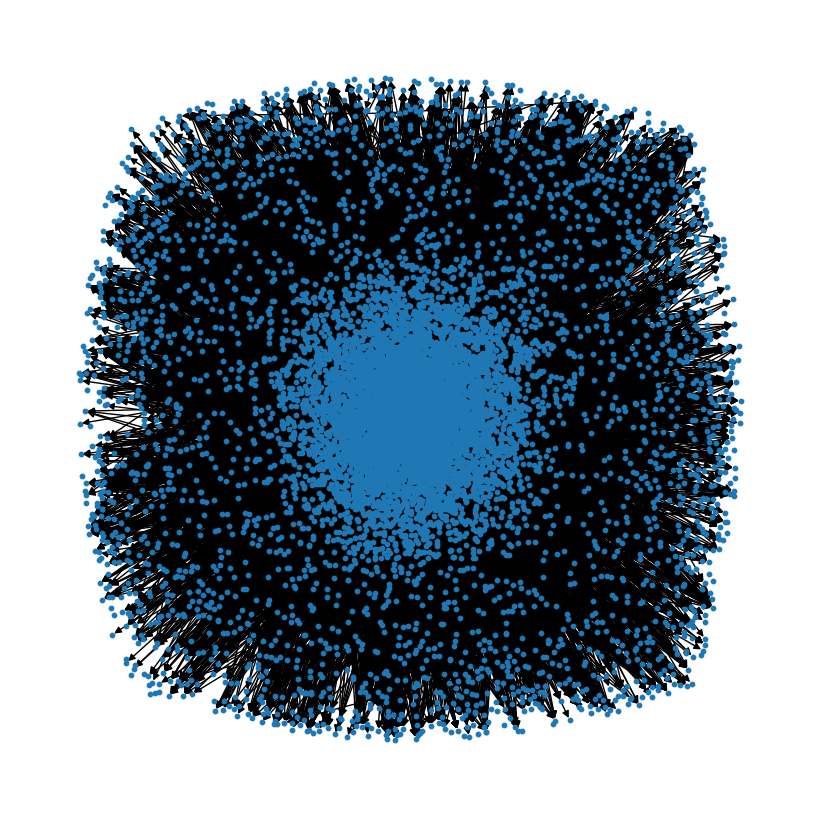

In [9]:
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(citation_graph, k=0.01, iterations=10)
nx.draw(citation_graph, pos, node_size=10, with_labels=False, arrows=True)
plt.show()

In [10]:
# collaboration graph initialization 
collaboration_graph = nx.Graph()

for _, row in top_10k_df.iterrows():
    authors = row['authors']
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author1, author2 = authors[i], authors[j]

            if collaboration_graph.has_edge(author1, author2):
                collaboration_graph[author1][author2]['weight'] += 1
            else:
                collaboration_graph.add_edge(author1, author2, weight=1)

print(f"collaboration graph has {collaboration_graph.number_of_nodes()} nodes, and {collaboration_graph.number_of_edges()} edges.")

collaboration graph has 21993 nodes, and 139157 edges.


In [28]:
# plt.figure(figsize=(8, 8))

# pos = nx.spring_layout(collaboration_graph, k=0.01, iterations=10)
# nx.draw_networkx_nodes(collaboration_graph, pos, node_size=10)

# for (author1, author2, data) in collaboration_graph.edges(data=True):
#     nx.draw_networkx_edges(collaboration_graph, pos, edgelist=[(author1, author2)], width=np.log(data['weight']) / 130)
    
# plt.axis('off')
# plt.show()

### 2. Controlling system
#### 2.1. Backend Implementation



Functionality 1 - Graph's features


In [12]:
def graph_features(graph):
    # number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()

    # graph density
    density = nx.density(graph)

    # list of degrees
    degrees = [degree for _, degree in graph.degree()]

    # average degree
    avg_degree = np.mean(degrees)

    # whether the graph is dense or sparse
    graph_type = "Dense" if density > 0.5 else "Sparse"

    # graph hubs 
    hubs = [node for node, degree in graph.degree() if degree > np.percentile(degrees, 95)]

    # degree distribution
    degree_distribution = collections.Counter(degrees)

    return {
        'Number of Nodes': num_nodes,
        'Number of Edges': num_edges,
        'Density': density,
        'Average Degree': avg_degree,
        'Graph Type': graph_type,
        'Hubs': hubs,
        'Degree Distribution': degree_distribution
    }

Functionality 2 - Nodes' contribution


In [20]:
def nodes_contribution(graph, node, graph_name):

    # betweenness centrality
    betweenness = nx.betweenness_centrality(graph)
    node_betweenness = betweenness.get(node, 'Node not found')

    # pagerank
    pagerank = nx.pagerank(graph)
    node_pagerank = pagerank.get(node, 'Node not found')

    # closeness centrality
    closeness = nx.closeness_centrality(graph)
    node_closeness = closeness.get(node, 'Node not found')

    # degree centrality
    degree_centrality = nx.degree_centrality(graph)
    node_degree_centrality = degree_centrality.get(node, 'Node not found')

    centrality = pd.DataFrame({
        'Centrality Measure': ['Betweenness', 'PageRank', 'Closeness', 'Degree'],
        f'Centrality of Node ({node}) in {graph_name}': [node_betweenness, node_pagerank, node_closeness, node_degree_centrality]
    })

    return centrality

#### 2.2. Frontend Implementation


Visualization 1 - Visualize graph features


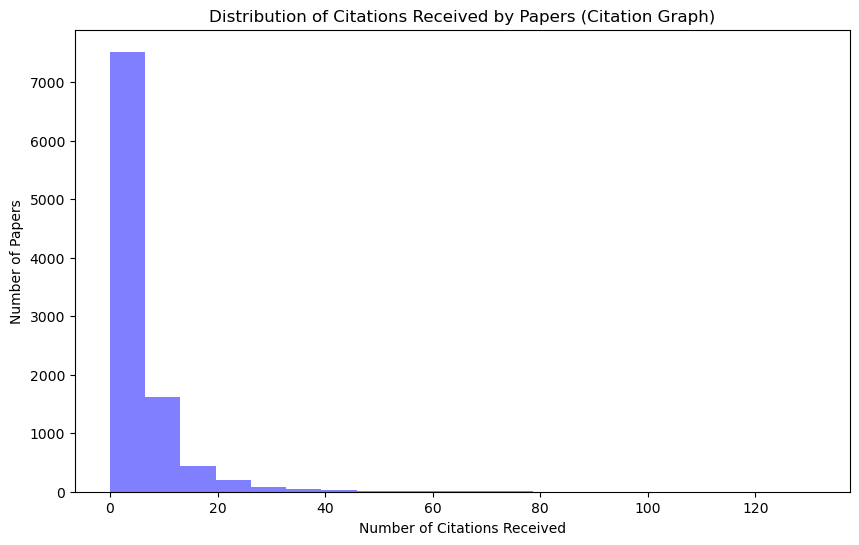

In [16]:
#citation graph visualization 

citation_graph_features = graph_features(citation_graph)

#general info about citation graph
citation_info_table = pd.DataFrame([citation_graph_features])

#hubs
citation_hubs = pd.DataFrame({'Hubs': citation_graph_features['Hubs']})

#distribution of the citations received by papers 
in_degrees = [degree for _, degree in citation_graph.in_degree()]
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=20, color='blue', alpha=0.5)
plt.title('Distribution of Citations Received by Papers (Citation Graph)')
plt.xlabel('Number of Citations Received')
plt.ylabel('Number of Papers')
plt.show()

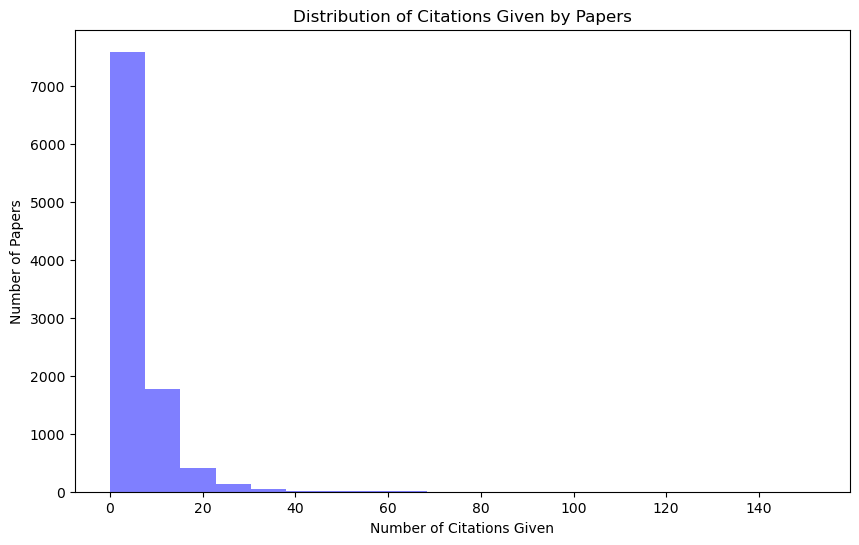

In [17]:
#distribution of the citations given by papers 
out_degrees = [degree for _, degree in citation_graph.out_degree()]
plt.figure(figsize=(10, 6))
plt.hist(out_degrees, bins=20, color='blue', alpha=0.5)
plt.title('Distribution of Citations Given by Papers')
plt.xlabel('Number of Citations Given')
plt.ylabel('Number of Papers')
plt.show()

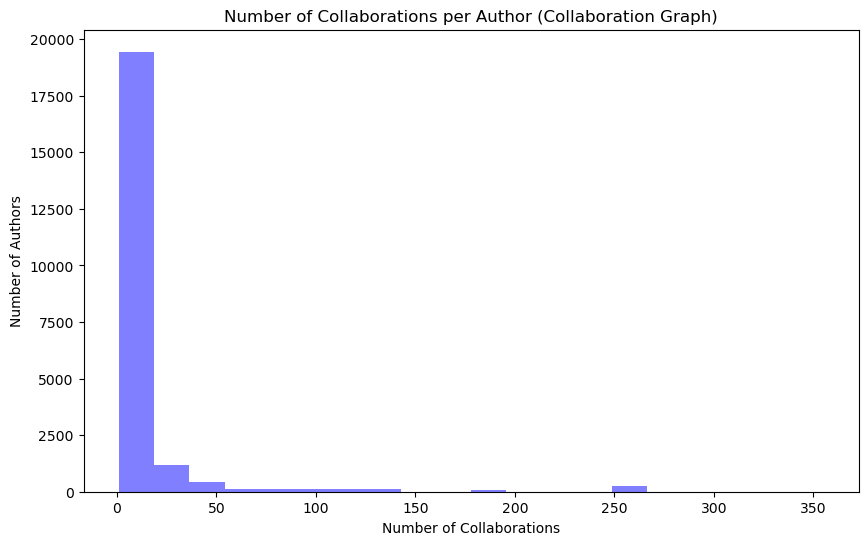

In [19]:
# number of collaborations of the author
collab_degrees = [degree for _, degree in collaboration_graph.degree()]
plt.figure(figsize=(10, 6))
plt.hist(collab_degrees, bins=20, color='blue', alpha=0.5)
plt.title('Number of Collaborations per Author (Collaboration Graph)')
plt.xlabel('Number of Collaborations')
plt.ylabel('Number of Authors')
plt.show()

Functionality 2 - Nodes' contribution


In [26]:
#citation graph centrality table 
citation_node = random.choice(list(citation_graph.nodes()))
citation_centrality = nodes_contribution(citation_graph, citation_node, "Citation Graph")

print(citation_centrality)

  Centrality Measure  Centrality of Node (2158241055) in Citation Graph
0        Betweenness                                       2.000600e-08
1           PageRank                                       5.234785e-05
2          Closeness                                       2.000200e-04
3             Degree                                       4.000400e-04


In [27]:
collaboration_node = random.choice(list(collaboration_graph.nodes()))
collaboration_centrality = nodes_contribution(collaboration_graph, collaboration_node, "Collaboration Graph")
print(collaboration_centrality)

  Centrality Measure  \
0        Betweenness   
1           PageRank   
2          Closeness   
3             Degree   

   Centrality of Node (Beatrice Bodega) in Collaboration Graph  
0                                           0.000000            
1                                           0.000049            
2                                           0.038155            
3                                           0.011822            
